<a href="https://colab.research.google.com/github/mohammed1916/ml/blob/main/Project/Brain_Tumor_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri/

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files

# Upload kaggle.json
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri/

 93% 81.0M/86.8M [00:01<00:00, 59.7MB/s]
100% 86.8M/86.8M [00:01<00:00, 57.6MB/s]


In [ ]:
!unzip -q brain-tumor-classification-mri.zip

**Import needed libraries**

In [ ]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
#---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
#---------------------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#---------------------------------------
import warnings
warnings.filterwarnings("ignore")

**Preprocessing**

In [ ]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [ ]:
tr_df = train_df('Training')
ts_df = test_df('Testing')

In [ ]:
tr_df

,Class Path,Class
0,Training/meningioma_tumor/m (112).jpg,meningioma_tumor
1,Training/meningioma_tumor/m (62).jpg,meningioma_tumor
2,Training/meningioma_tumor/m3 (61).jpg,meningioma_tumor
3,Training/meningioma_tumor/m (41).jpg,meningioma_tumor
4,Training/meningioma_tumor/m (187).jpg,meningioma_tumor
...,...,...
2865,Training/no_tumor/image(72).jpg,no_tumor
2866,Training/no_tumor/image (34).jpg,no_tumor
2867,Training/no_tumor/image(138).jpg,no_tumor
2868,Training/no_tumor/image(76).jpg,no_tumor


In [ ]:
ts_df

,Class Path,Class
0,Testing/meningioma_tumor/image(80).jpg,meningioma_tumor
1,Testing/meningioma_tumor/image(97).jpg,meningioma_tumor
2,Testing/meningioma_tumor/image(84).jpg,meningioma_tumor
3,Testing/meningioma_tumor/image(22).jpg,meningioma_tumor
4,Testing/meningioma_tumor/image(92).jpg,meningioma_tumor
...,...,...
389,Testing/no_tumor/image(45).jpg,no_tumor
390,Testing/no_tumor/image(51).jpg,no_tumor
391,Testing/no_tumor/image(78).jpg,no_tumor
392,Testing/no_tumor/image(72).jpg,no_tumor


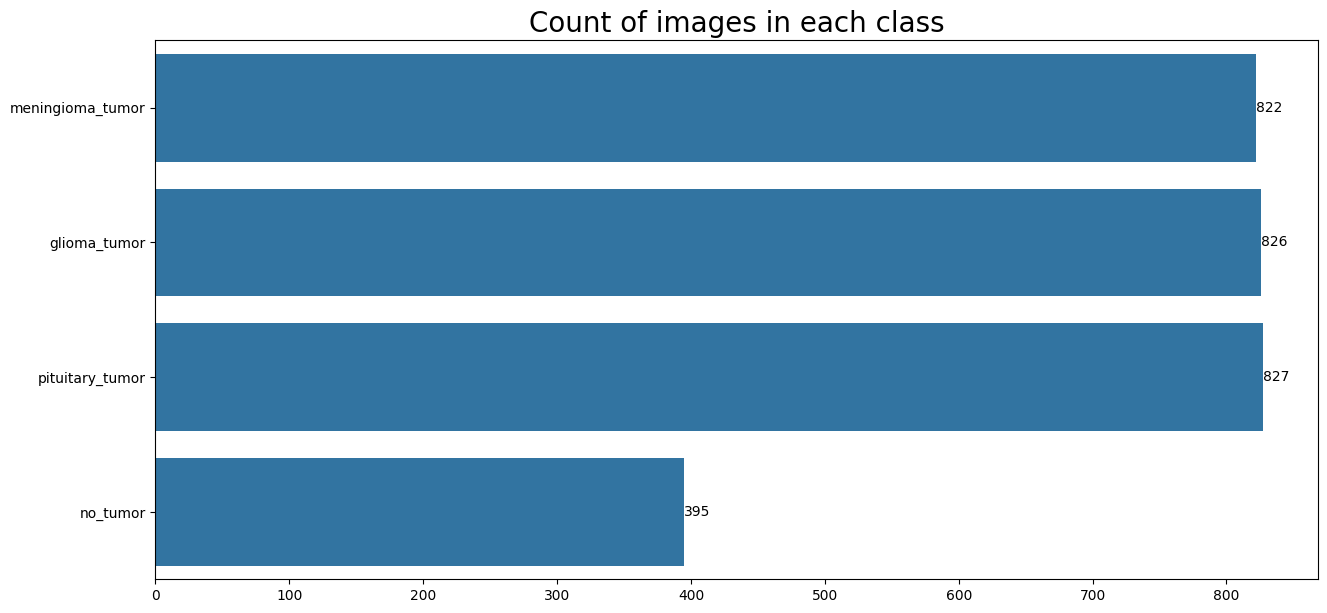

In [ ]:
# Count of images in each class in train data
plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df , y=tr_df['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

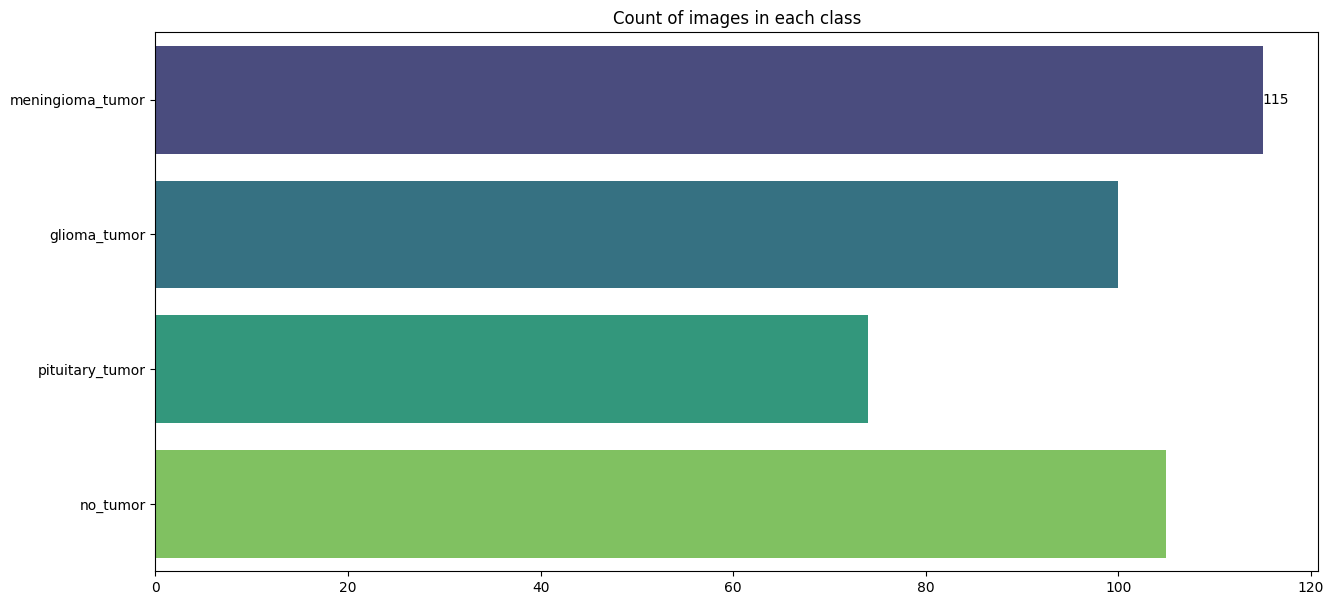

In [ ]:
#Count each class in test data
plt.figure(figsize=(15, 7))
ax = sns.countplot(y=ts_df['Class'], palette='viridis')

ax.set(xlabel='', ylabel='', title='Count of images in each class')
ax.bar_label(ax.containers[0])

plt.show()

**Train Test Valid data**

In [ ]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=20, stratify=ts_df['Class'])

In [ ]:
valid_df

,Class Path,Class
350,Testing/no_tumor/image(52).jpg,no_tumor
264,Testing/pituitary_tumor/image(77).jpg,pituitary_tumor
145,Testing/glioma_tumor/image(19).jpg,glioma_tumor
249,Testing/pituitary_tumor/image(43).jpg,pituitary_tumor
334,Testing/no_tumor/image(53).jpg,no_tumor
...,...,...
153,Testing/glioma_tumor/image(34).jpg,glioma_tumor
271,Testing/pituitary_tumor/image(38).jpg,pituitary_tumor
234,Testing/pituitary_tumor/image(67).jpg,pituitary_tumor
1,Testing/meningioma_tumor/image(97).jpg,meningioma_tumor


In [ ]:
batch_size = 32
img_size = (299, 299)

_gen = ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)


tr_gen = _gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 2870 validated image filenames belonging to 4 classes.
Found 197 validated image filenames belonging to 4 classes.
Found 197 validated image filenames belonging to 4 classes.


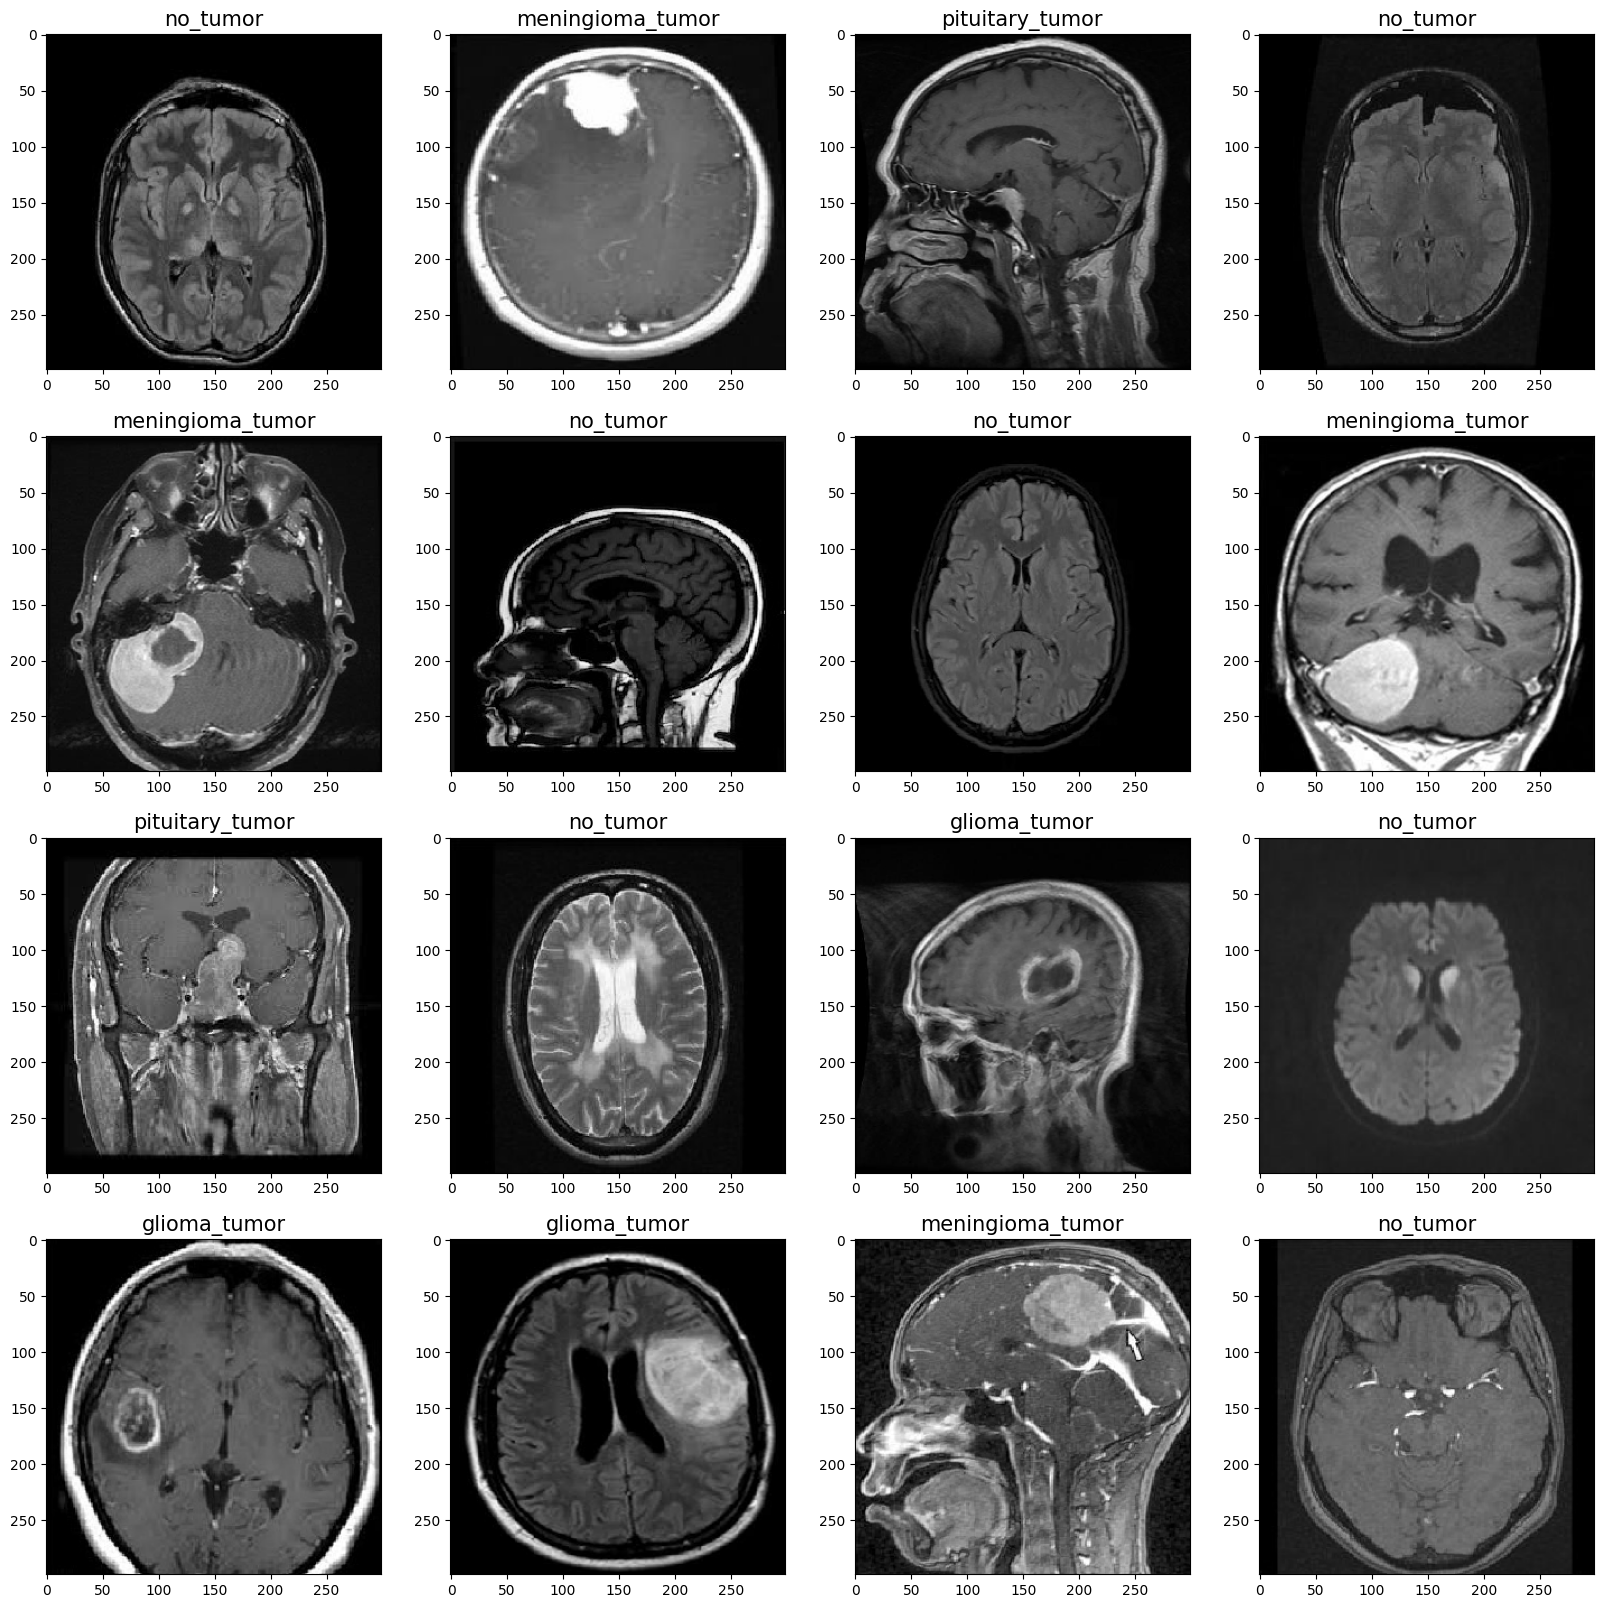

In [ ]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4,4, i + 1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)

plt.show()

**Model Building**

In [ ]:
img_shape=(299,299,3)
base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

# for layer in base_model.layers:
#     layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

model.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                         

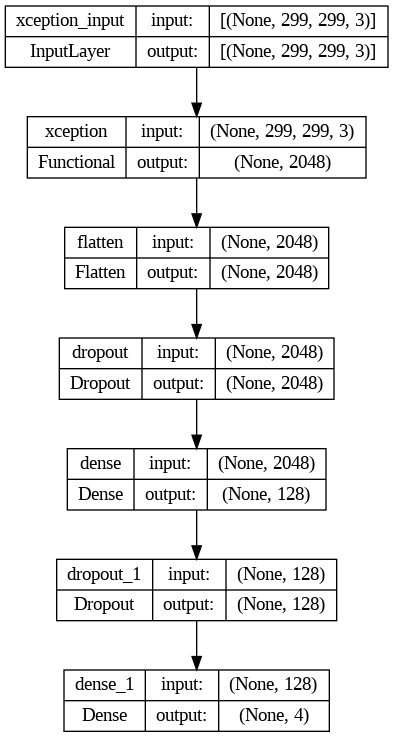

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

**Fit the Model**

In [ ]:
hist = model.fit(tr_gen,
                 epochs=10,
                 validation_data=valid_gen,
                 shuffle= False)

Epoch 1/10
90/90 [==============================] - 132s 1s/step - loss: 1.4172 - accuracy: 0.2882 - precision: 0.4661 - recall: 0.0192 - val_loss: 1.5560 - val_accuracy: 0.2893 - val_precision: 0.1500 - val_recall: 0.0457
Epoch 2/10
90/90 [==============================] - 83s 919ms/step - loss: 1.2149 - accuracy: 0.4307 - precision: 0.5458 - recall: 0.1038 - val_loss: 1.4043 - val_accuracy: 0.2081 - val_precision: 1.0000 - val_recall: 0.0152
Epoch 3/10
90/90 [==============================] - 82s 915ms/step - loss: 1.1032 - accuracy: 0.5376 - precision: 0.6480 - recall: 0.1892 - val_loss: 1.4036 - val_accuracy: 0.1929 - val_precision: 0.6250 - val_recall: 0.0254
Epoch 4/10
90/90 [==============================] - 84s 930ms/step - loss: 0.9101 - accuracy: 0.6836 - precision: 0.8382 - recall: 0.3683 - val_loss: 1.4021 - val_accuracy: 0.1827 - val_precision: 1.0000 - val_recall: 0.0152
Epoch 5/10
90/90 [==============================] - 84s 930ms/step - loss: 0.7959 - accuracy: 0.7352 -

In [ ]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

**Visualize Model Performance**

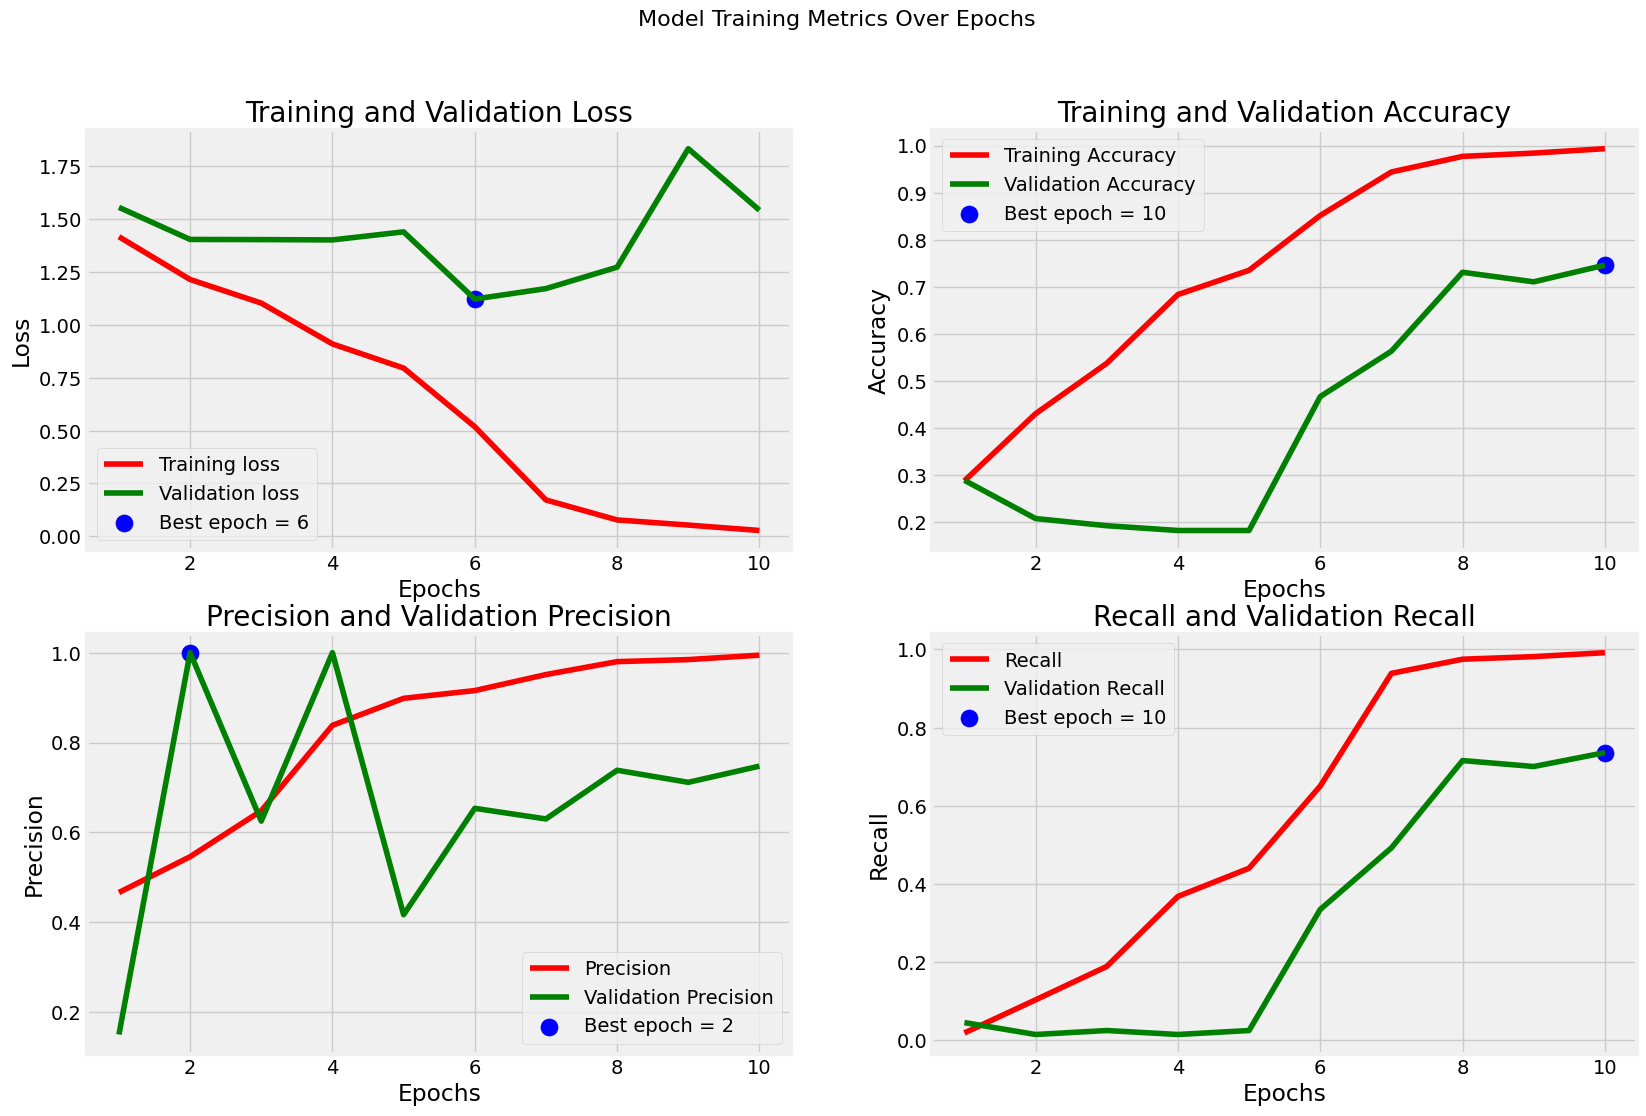

In [ ]:
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision']
tr_recall = hist.history['recall']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision']
val_recall = hist.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

Testing and Evaluation

In [ ]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

13/13 [==============================] - 5s 124ms/step - loss: 1.0213 - accuracy: 0.7817 - precision: 0.7937 - recall: 0.7614
Train Loss: 0.0132
Train Accuracy: 99.62%
--------------------
Validation Loss: 1.4905
Validation Accuracy: 74.62%
--------------------
Test Loss: 1.0213
Test Accuracy: 78.17%


In [ ]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

13/13 [==============================] - 2s 137ms/step


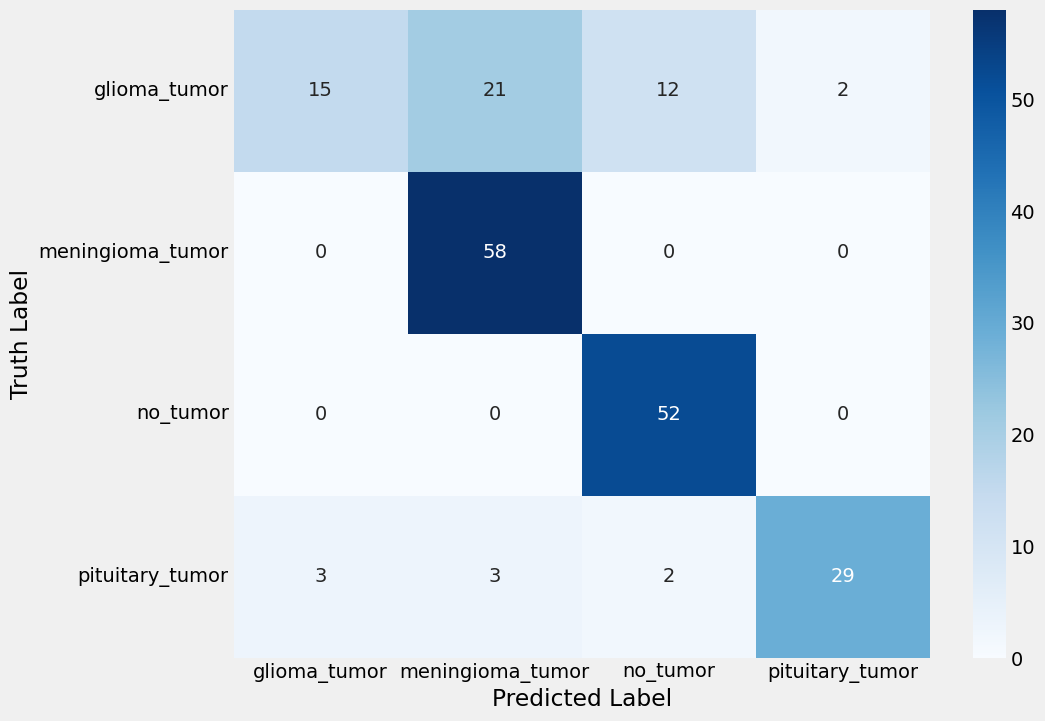

In [ ]:
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [ ]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.83      0.30      0.44        50
           1       0.71      1.00      0.83        58
           2       0.79      1.00      0.88        52
           3       0.94      0.78      0.85        37

    accuracy                           0.78       197
   macro avg       0.82      0.77      0.75       197
weighted avg       0.80      0.78      0.75       197



TEsting

In [ ]:
def predict(img_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    label = list(class_dict.keys())
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    resized_img = img.resize((299, 299))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

1/1 [==============================] - 2s 2s/step


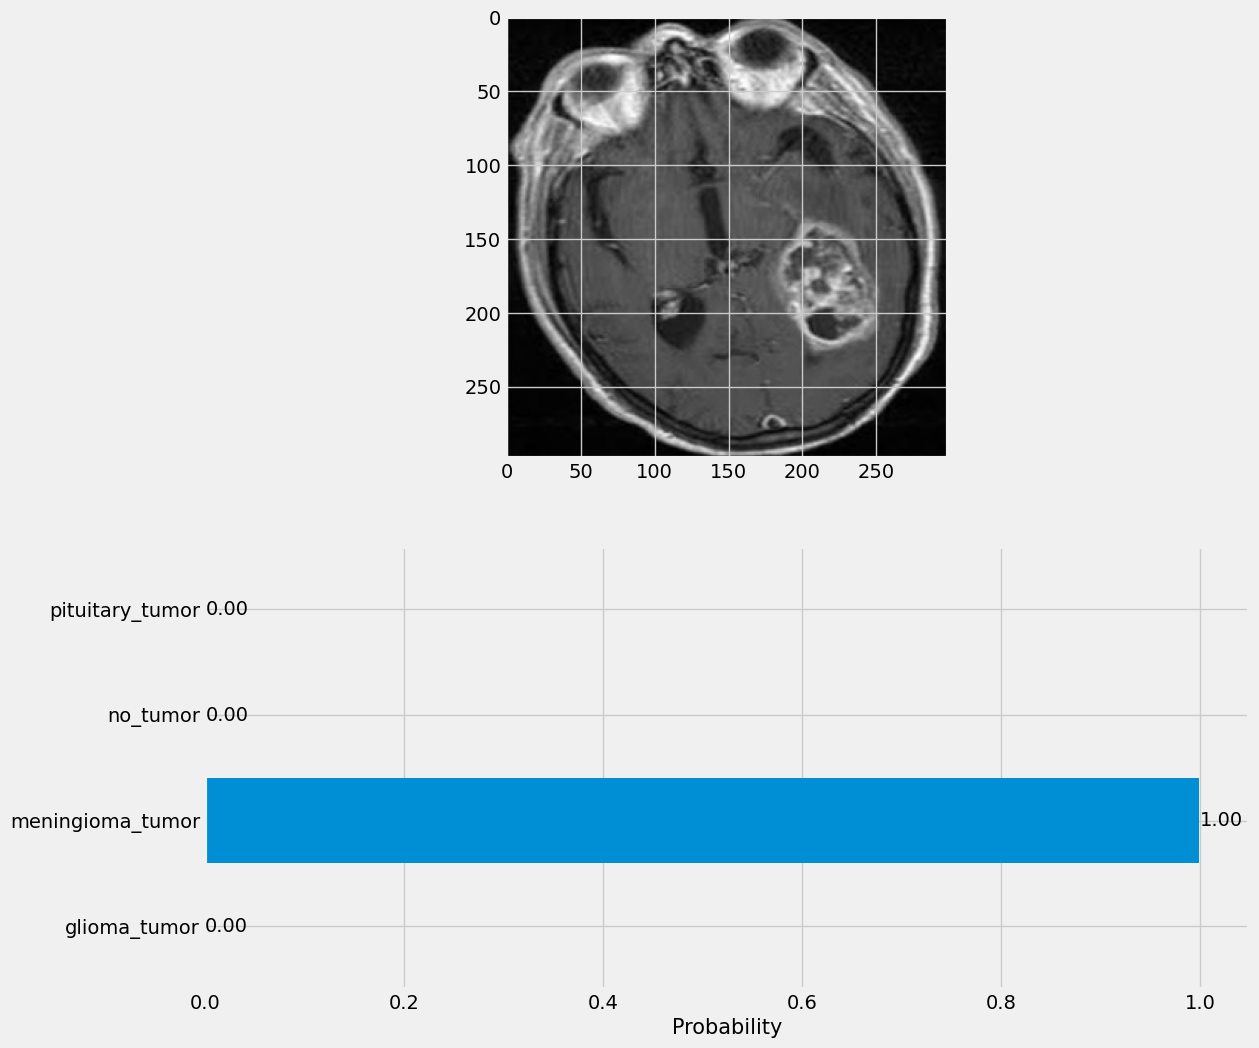

In [ ]:
predict('/content/Testing/meningioma_tumor/image(10).jpg')

1/1 [==============================] - 0s 23ms/step


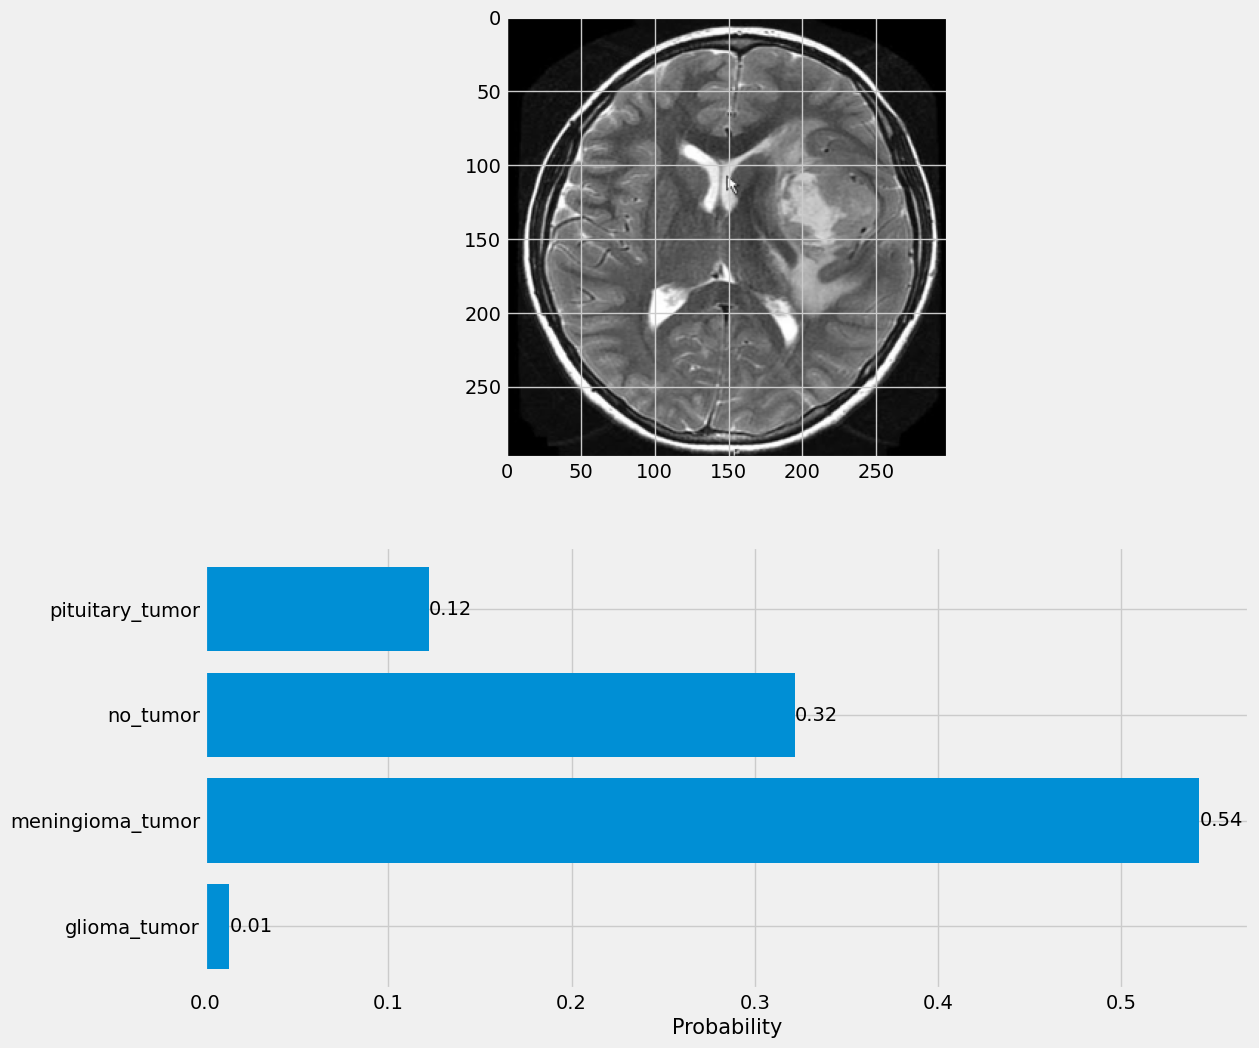

In [ ]:
predict('/content/Testing/glioma_tumor/image(18).jpg')

1/1 [==============================] - 0s 42ms/step


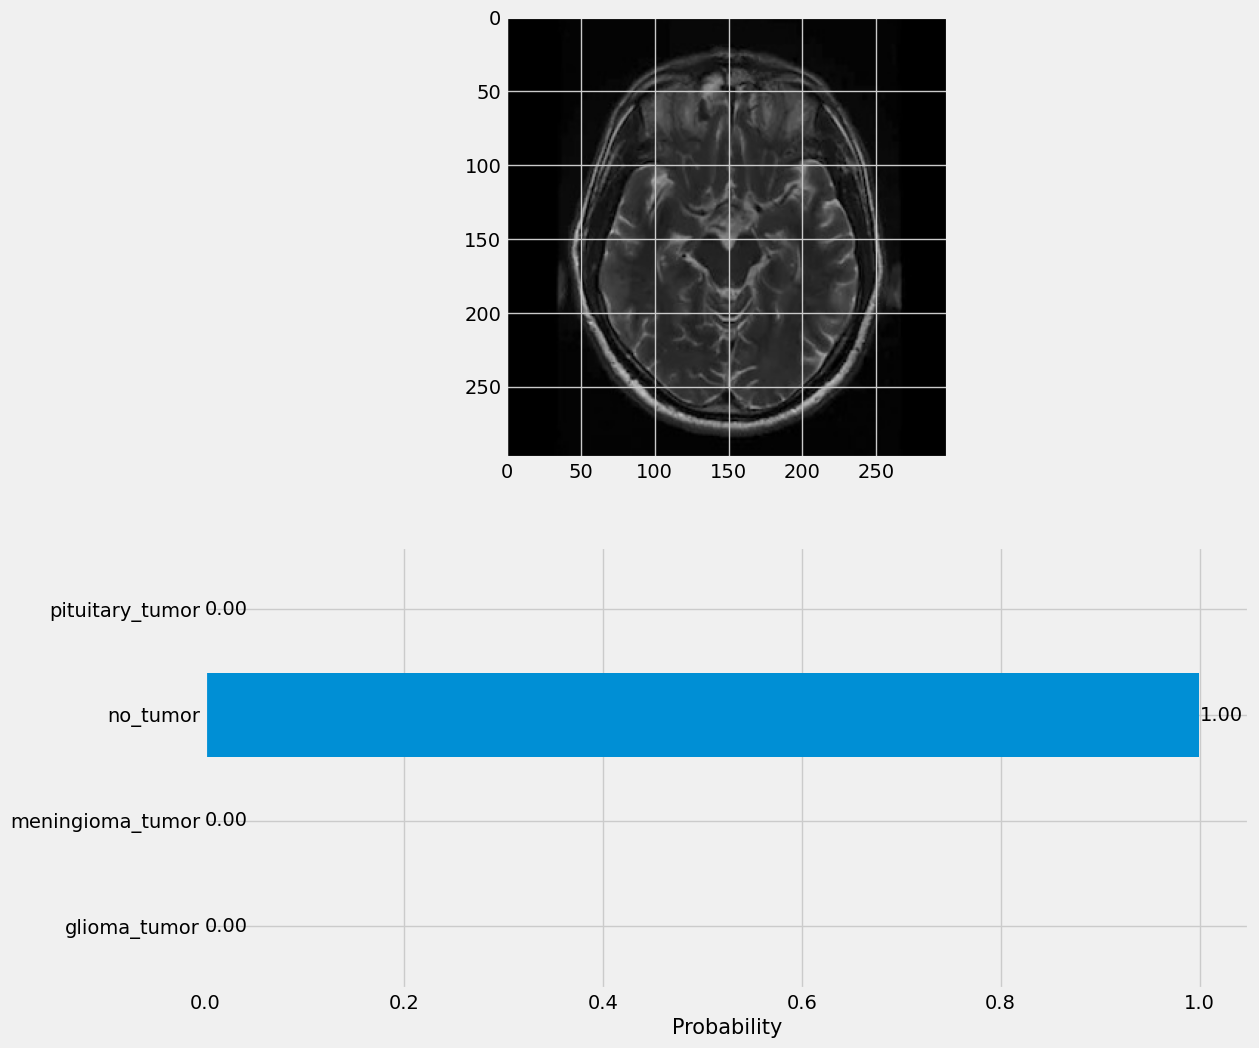

In [ ]:
predict('/content/Testing/no_tumor/image(104).jpg')

1/1 [==============================] - 0s 24ms/step


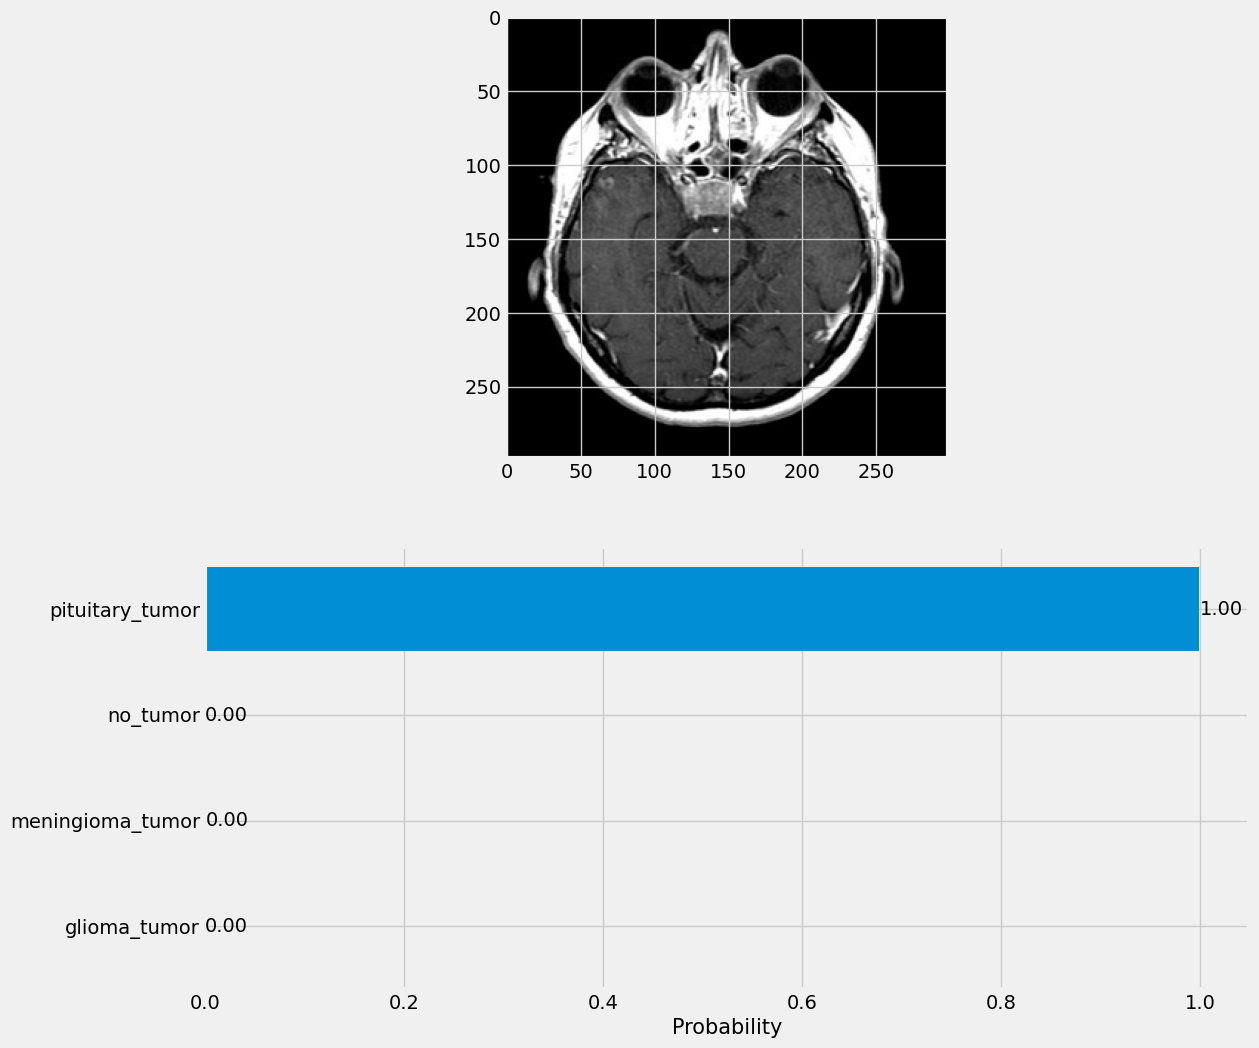

In [ ]:
predict('/content/Testing/pituitary_tumor/image(22).jpg')

**Real Time Testing**

1/1 [==============================] - 0s 103ms/step


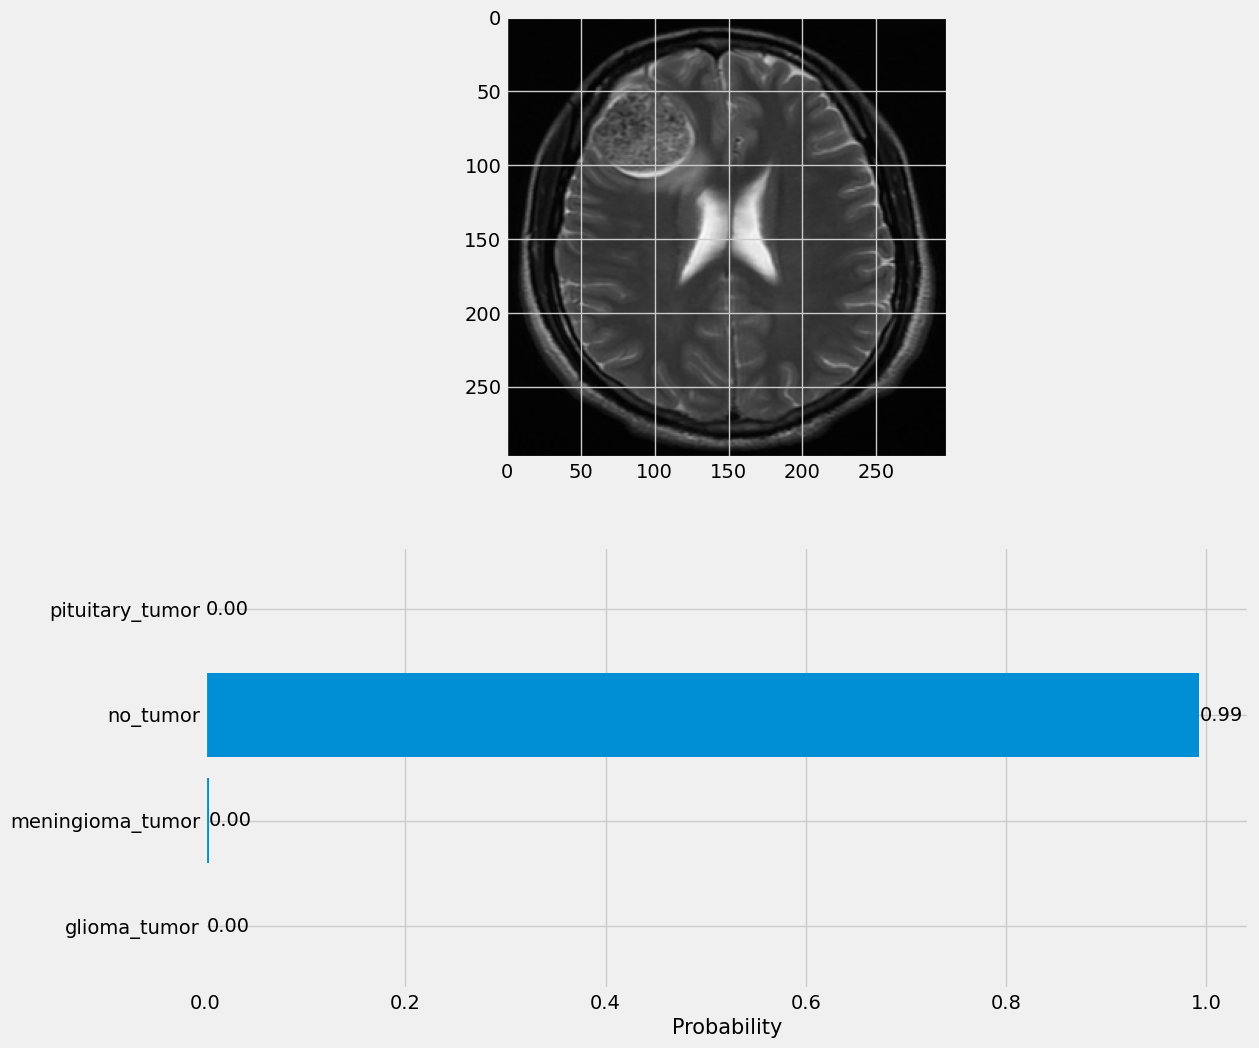

In [ ]:
predict('/content/PMC3132124_rt-2011-2-e20-g001.png')

1/1 [==============================] - 0s 21ms/step


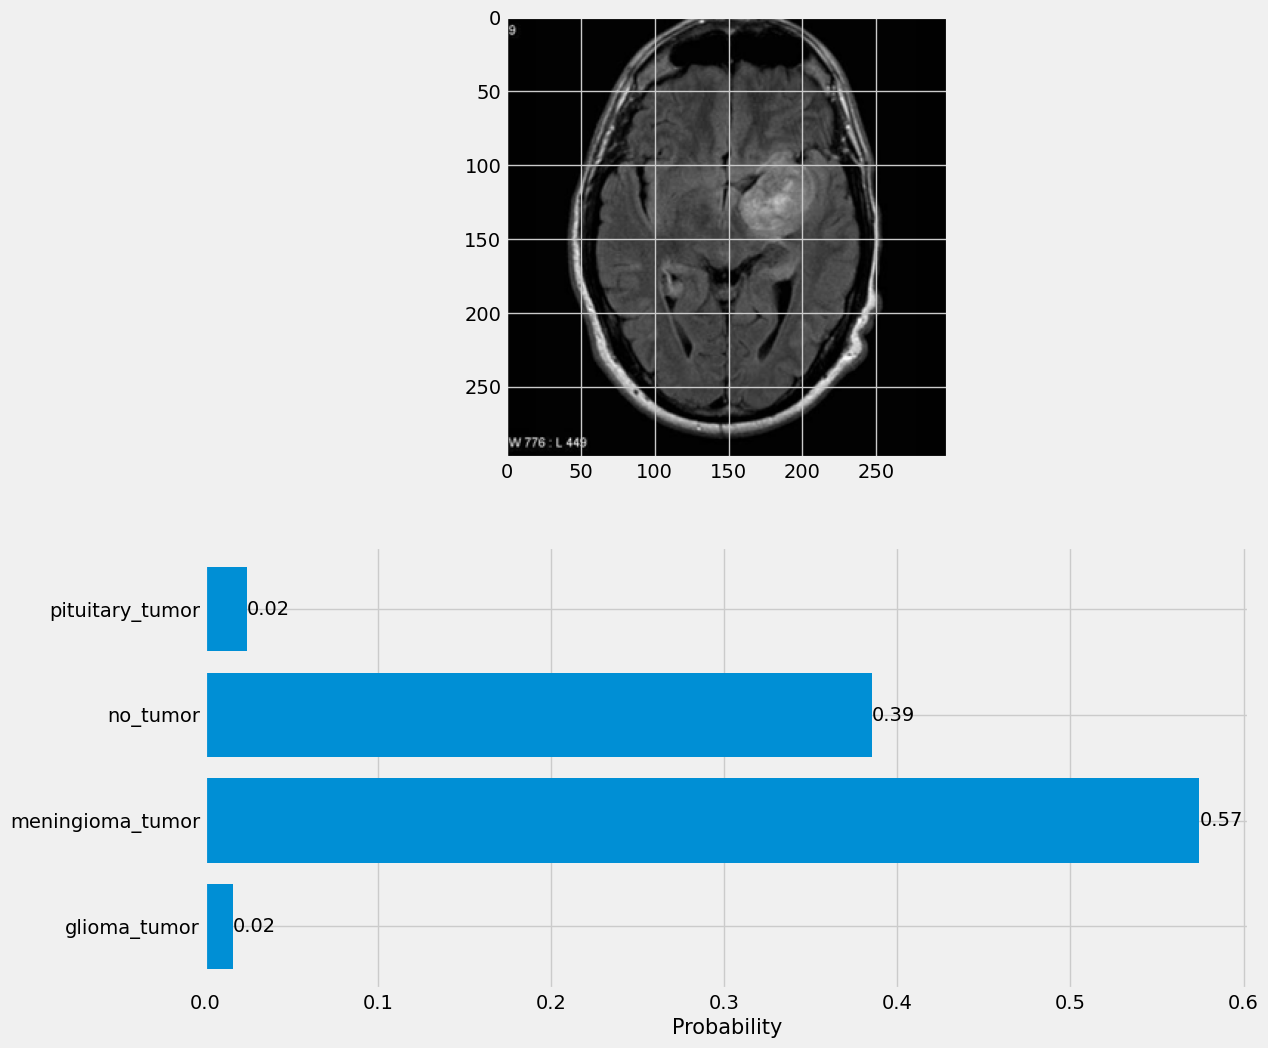

In [ ]:
predict('/content/meningioma1.jpeg')

**Save the Model**

In [ ]:
model.save('cnn_model.h5')

In [ ]:
from google.colab import files

# Replace 'trained_model.h5' or 'trained_model.pth' with the actual filename
files.download('cnn_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>